### Importing Libraries

In [3]:
!pip install pulp

  Using cached PuLP-2.9.0-py3-none-any.whl.metadata (5.4 kB)
Using cached PuLP-2.9.0-py3-none-any.whl (17.7 MB)


In [15]:
import warnings

# To ignore all warnings:
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### Loading data

In [12]:
# Load rental data
rental_data = pd.read_csv('rental_data.csv')  # Adjust delimiter as needed

# Load charge probabilities
charge_probabilities = pd.read_csv('charge_probabilites.csv', delimiter=';')


In [13]:
# Preview datasets
print(rental_data.head());
print(charge_probabilities.head());

print("\n")

# Check for missing values or inconsistencies
print(rental_data.info());
print(charge_probabilities.info());


  Rental_state                        Start                          End  \
0          RED  2017-04-18 20:13:45.2790000  2017-04-18 20:30:13.0410000   
1        GREEN  2017-09-17 19:06:00.9820000  2017-09-17 19:07:15.8960000   
2          RED  2017-07-28 21:56:11.4990000  2017-07-28 22:06:50.3140000   
3        GREEN  2017-01-31 21:31:57.8780000  2017-01-31 21:50:07.8720000   
4          RED  2017-08-09 20:34:39.6860000  2017-08-09 20:49:32.0390000   

   Revenue  Distance  
0     4.43         8  
1     0.00         0  
2     2.87         3  
3     0.00         0  
4     2.82         5  
   Incentive  Charging_probability
0          0                     0
1          5                     8
2         10                    16
3         15                    24
4         20                    32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   ----

### Simulation - PART ONE

Simulate battery levels, test various incentives, and analyze their effect on net revenue. The simulation incorporates various parameters and includes optimization to find the best combination of battery threshold and incentive

#### For Minimizing cost

    Threshold  Incentive  Total_Service_Cost  Total_Incentive_Cost  Total_Cost
0          20          0                   6                   2.9         8.9
1          20          5                   0               52307.3     52307.3
2          20         10                   0               92655.0     92655.0
3          20         15                   0              126521.2    126521.2
4          20         20                   0              155611.1    155611.1
5          20         25                   0              180646.8    180646.8
6          20         30                   0              201407.9    201407.9
7          20         35                   0              220188.3    220188.3
8          20         40                   0              236460.2    236460.2
9          20         45                   0              250087.3    250087.3
10         20         50                   0              263183.7    263183.7
11         25          0                   6        

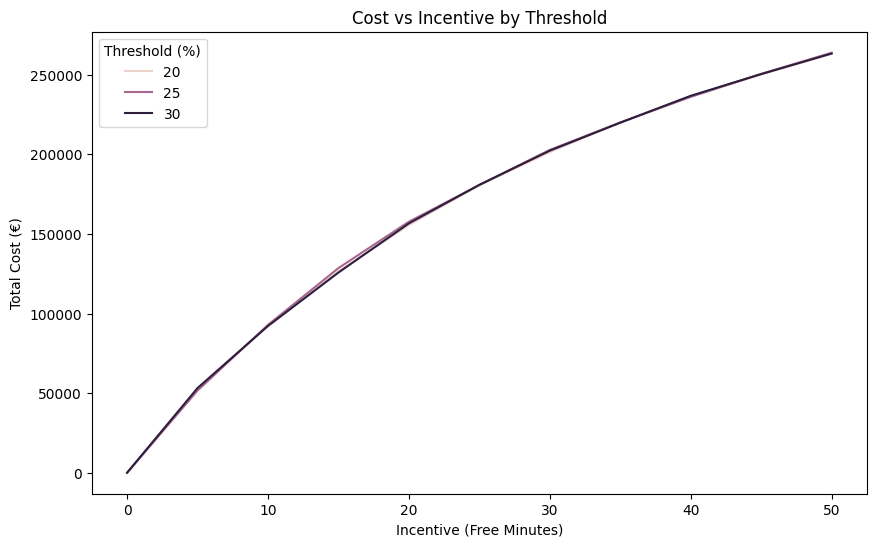

Optimal Battery Threshold: 20.00%
Optimal Incentive: 10.00 minutes


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# Load rental data
rental_data = pd.read_csv('rental_data.csv') # Adjust delimiter as needed

# Load charge probabilities
charge_probabilities = pd.read_csv('charge_probabilites.csv', delimiter=';')

# Convert 'Start' and 'End' columns to datetime
rental_data['Start'] = pd.to_datetime(rental_data['Start'])
rental_data['End'] = pd.to_datetime(rental_data['End'])

# Calculate durations in minutes
rental_data['Duration'] = (rental_data['End'] - rental_data['Start']).dt.total_seconds() / 60

# Simulation parameters
battery_threshold = 20  # Minimum battery level for rentals
service_team_cost = 6  # Cost of service team intervention (€)
incentive_cost_per_min = 0.29  # Cost of one free minute (€)
initial_battery = 100  # Starting battery level (%)
waiting_time = 180  # Waiting time for service team to charge (in minutes)

# Battery consumption during rental: 0.5% per km
rental_data['Battery_Consumption'] = rental_data['Distance'] * 0.005  # 0.5% per km

# Function to simulate user charging behavior
def simulate_user_charging(battery_level, incentive, probabilities):
    if incentive not in probabilities['Incentive'].values:
        return battery_level  # If the incentive is invalid, no charging happens

    charging_prob = probabilities.loc[probabilities['Incentive'] == incentive, 'Charging_probability'].values[0]
    if np.random.rand() * 100 < charging_prob:
        return 100  # Assume full charge if user charges
    return battery_level

# Function to simulate battery level after rentals
def simulate_battery_level(rental_data, initial_battery, battery_threshold, incentive, charge_probabilities):
    battery_level = initial_battery
    battery_levels = []
    waiting_time_remaining = 0  # Track remaining waiting time
    service_interventions = 0  # Count service interventions

    for _, row in rental_data.iterrows():
        if row['Rental_state'] == 'RED':
            battery_level -= row['Battery_Consumption']

        if battery_level < battery_threshold and waiting_time_remaining == 0:
            waiting_time_remaining = waiting_time
            service_interventions += 1

        if waiting_time_remaining > 0:
            waiting_time_remaining -= row['Duration']
            if waiting_time_remaining <= 0:
                battery_level = initial_battery

        if waiting_time_remaining <= 0:
            battery_level = simulate_user_charging(battery_level, incentive, charge_probabilities)

        battery_level = min(battery_level, 100)
        battery_levels.append(battery_level)

    rental_data['Battery_Level'] = battery_levels
    return rental_data, service_interventions

# Initialize result storage
results = []
battery_thresholds = [20, 25, 30]  # Battery thresholds for intervention
incentives = list(range(0, 50 + 5, 5))  # Incentives from 0 to 50 in steps of 5

# Simulate scenarios
for threshold in battery_thresholds:
    for incentive in incentives:
        if incentive not in charge_probabilities['Incentive'].values:
            continue

        rental_data_simulated, service_interventions = simulate_battery_level(
            rental_data, initial_battery, threshold, incentive, charge_probabilities
        )

        total_service_cost = service_interventions * service_team_cost
        total_incentive_cost = rental_data_simulated[rental_data_simulated['Battery_Level'] == 100].shape[0] * (incentive_cost_per_min * 10)
        total_cost = total_service_cost + total_incentive_cost

        results.append({
            'Threshold': threshold,
            'Incentive': incentive,
            'Total_Service_Cost': total_service_cost,
            'Total_Incentive_Cost': total_incentive_cost,
            'Total_Cost': total_cost
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

results_df.to_csv('results_incentive cost.csv', index=False)

# Summarize total costs
summary = results_df.groupby(['Threshold', 'Incentive']).agg({
    'Total_Service_Cost': 'sum',
    'Total_Incentive_Cost': 'sum',
    'Total_Cost': 'sum'
}).reset_index()

# Display summary
print(summary)

# Visualize total costs
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Incentive', y='Total_Cost', hue='Threshold')
plt.title('Cost vs Incentive by Threshold')
plt.xlabel('Incentive (Free Minutes)')
plt.ylabel('Total Cost (€)')
plt.legend(title='Threshold (%)')
plt.show()

# Optimization Function
def objective_function(params, rental_data, charge_probabilities):
    threshold, incentive = params

    if incentive not in charge_probabilities['Incentive'].values:
        return np.inf

    rental_data_simulated, service_interventions = simulate_battery_level(
        rental_data, initial_battery, threshold, incentive, charge_probabilities
    )

    total_service_cost = service_interventions * service_team_cost
    total_incentive_cost = rental_data_simulated[rental_data_simulated['Battery_Level'] == 100].shape[0] * (incentive_cost_per_min * 10)
    total_cost = total_service_cost + total_incentive_cost

    return total_cost

# Define bounds for optimization
bounds = [(20, 30), (0, 50)]

# Initial guess
initial_guess = [battery_threshold, 10]

# Run optimization
result = minimize(objective_function, initial_guess, args=(rental_data, charge_probabilities), bounds=bounds, method='L-BFGS-B')

optimal_threshold, optimal_incentive = result.x
print(f"Optimal Battery Threshold: {optimal_threshold:.2f}%")
print(f"Optimal Incentive: {optimal_incentive:.2f} minutes")


#### For Minimizing Negative Net Revenue (Revenue - Cost)

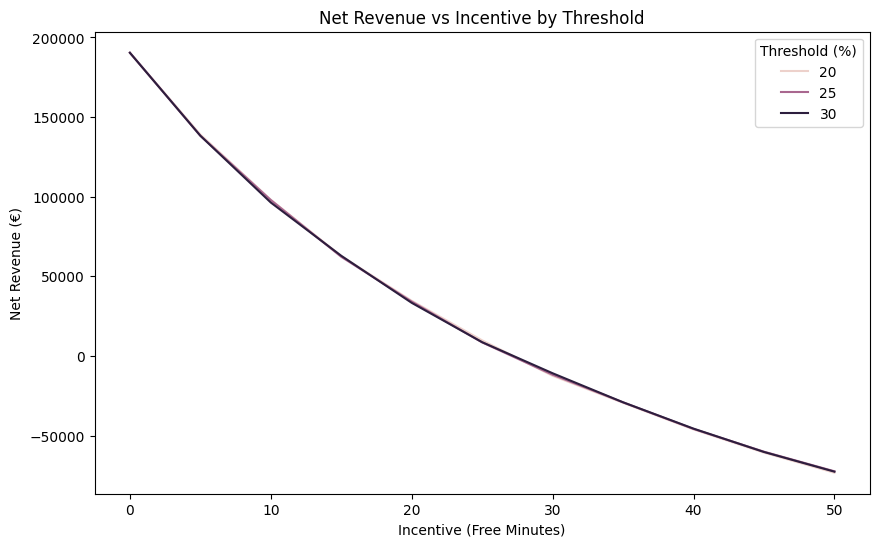

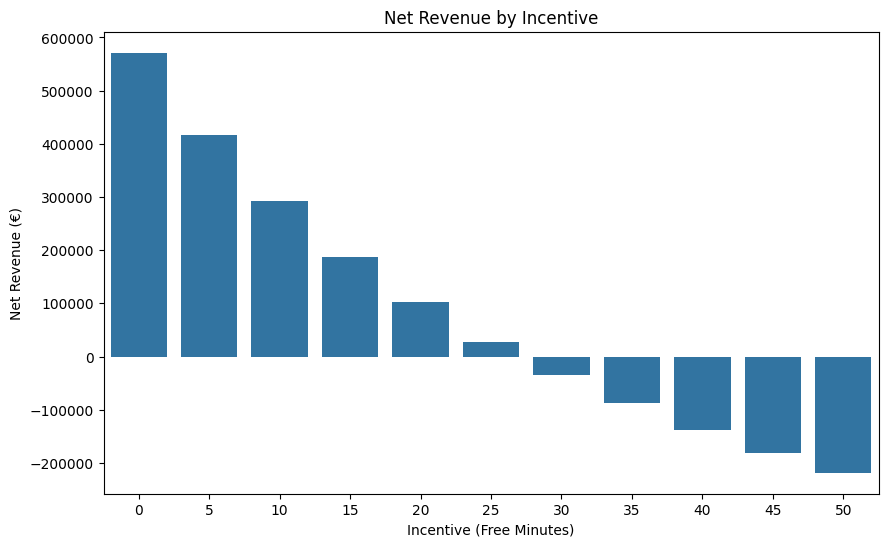

Optimal Battery Threshold: 20.00%
Optimal Incentive: 5.00 minutes
Optimal Total Service Cost: €0
Optimal Total Incentive Cost: €50912.4
Optimal Total Cost: €50912.4
Optimal Total Revenue: €190412.06000000003
Optimal Net Revenue: €139499.66000000003


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# Load rental data
rental_data = pd.read_csv('rental_data.csv')  # Load the entire dataset for simulation

# Load charge probabilities
charge_probabilities = pd.read_csv('charge_probabilites.csv', delimiter=';')

# Convert 'Start' and 'End' columns to datetime
rental_data['Start'] = pd.to_datetime(rental_data['Start'])
rental_data['End'] = pd.to_datetime(rental_data['End'])

# Calculate durations in minutes
rental_data['Duration'] = (rental_data['End'] - rental_data['Start']).dt.total_seconds() / 60

# Simulation parameters
battery_threshold = 20  # Minimum battery level for rentals
service_team_cost = 6  # Cost of service team intervention (€)
incentive_cost_per_min = 0.29  # Cost of one free minute (€)
initial_battery = 100  # Starting battery level (%)
waiting_time = 180  # Waiting time for service team to charge (in minutes)

# Battery consumption during rental: 0.5% per km
rental_data['Battery_Consumption'] = rental_data['Distance'] * 0.005  # 0.5% per km

# Function to simulate user charging behavior
def simulate_user_charging(battery_level, incentive, probabilities):
    if incentive not in probabilities['Incentive'].values:
        return battery_level  # If the incentive is invalid, no charging happens

    charging_prob = probabilities.loc[probabilities['Incentive'] == incentive, 'Charging_probability'].values[0]
    if np.random.rand() * 100 < charging_prob:
        return 100  # Assume full charge if user charges
    return battery_level

# Function to simulate battery level after rentals
def simulate_battery_level(rental_data, initial_battery, battery_threshold, incentive, charge_probabilities):
    battery_level = initial_battery
    battery_levels = []
    waiting_time_remaining = 0  # Track remaining waiting time
    service_interventions = 0  # Count service interventions

    for _, row in rental_data.iterrows():
        if row['Rental_state'] == 'RED':
            battery_level -= row['Battery_Consumption']

        if battery_level < battery_threshold and waiting_time_remaining == 0:
            waiting_time_remaining = waiting_time
            service_interventions += 1

        if waiting_time_remaining > 0:
            waiting_time_remaining -= row['Duration']
            if waiting_time_remaining <= 0:
                battery_level = initial_battery

        if waiting_time_remaining <= 0:
            battery_level = simulate_user_charging(battery_level, incentive, charge_probabilities)

        battery_level = min(battery_level, 100)
        battery_levels.append(battery_level)

    rental_data['Battery_Level'] = battery_levels
    return rental_data, service_interventions

# Initialize result storage
results = []
battery_thresholds = [20, 25, 30]  # Battery thresholds for intervention
incentives = list(range(0, 50 + 5, 5))  # Incentives from 0 to 50 in steps of 5

# Simulate scenarios with revenue impact
for threshold in battery_thresholds:
    for incentive in incentives:
        if incentive not in charge_probabilities['Incentive'].values:
            continue

        rental_data_simulated, service_interventions = simulate_battery_level(
            rental_data, initial_battery, threshold, incentive, charge_probabilities
        )

        total_service_cost = service_interventions * service_team_cost
        total_incentive_cost = rental_data_simulated[rental_data_simulated['Battery_Level'] == 100].shape[0] * (incentive_cost_per_min * 10)
        total_cost = total_service_cost + total_incentive_cost
        total_revenue = rental_data_simulated['Revenue'].sum()  # Sum up revenue
        net_revenue = total_revenue - total_cost  # Calculate net revenue

        results.append({
            'Threshold': threshold,
            'Incentive': incentive,
            'Total_Service_Cost': total_service_cost,
            'Total_Incentive_Cost': total_incentive_cost,
            'Total_Cost': total_cost,
            'Total_Revenue': total_revenue,
            'Net_Revenue': net_revenue
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

results_df.to_csv('results_revenue.csv', index=False)

# Summarize total costs and revenue
summary = results_df.groupby(['Threshold', 'Incentive']).agg({
    'Total_Service_Cost': 'sum',
    'Total_Incentive_Cost': 'sum',
    'Total_Cost': 'sum',
    'Total_Revenue': 'sum',
    'Net_Revenue': 'sum'
}).reset_index()

# Display summary
# print(summary)

# Visualize Net Revenue
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Incentive', y='Net_Revenue', hue='Threshold')
plt.title('Net Revenue vs Incentive by Threshold')
plt.xlabel('Incentive (Free Minutes)')
plt.ylabel('Net Revenue (€)')
plt.legend(title='Threshold (%)')
plt.show()

# Analyze the impact of incentives on net revenue
incentive_impact = results_df.groupby('Incentive')['Net_Revenue'].sum().reset_index()

# Visualize incentive impact on net revenue
plt.figure(figsize=(10, 6))
sns.barplot(data=incentive_impact, x='Incentive', y='Net_Revenue')
plt.title('Net Revenue by Incentive')
plt.xlabel('Incentive (Free Minutes)')
plt.ylabel('Net Revenue (€)')
plt.show()

# Optimization Function
def objective_function(params, rental_data, charge_probabilities):
    threshold, incentive = params

    if incentive not in charge_probabilities['Incentive'].values:
        return np.inf

    rental_data_simulated, service_interventions = simulate_battery_level(
        rental_data, initial_battery, threshold, incentive, charge_probabilities
    )

    total_service_cost = service_interventions * service_team_cost
    total_incentive_cost = rental_data_simulated[rental_data_simulated['Battery_Level'] == 100].shape[0] * (incentive_cost_per_min * 10)
    total_cost = total_service_cost + total_incentive_cost
    total_revenue = rental_data_simulated['Revenue'].sum()
    net_revenue = total_revenue - total_cost

    return -net_revenue  # Minimize negative net revenue to maximize net revenue

# Define bounds for optimization
bounds = [(20, 30), (0, 50)]  # Battery threshold between 20% and 30%, incentive between 0 and 50 free minutes

# Initial guess
initial_guess = [battery_threshold, 5] #Adjust

# Run optimization
result = minimize(objective_function, initial_guess, args=(rental_data, charge_probabilities), bounds=bounds, method='L-BFGS-B')

optimal_threshold, optimal_incentive = result.x
print(f"Optimal Battery Threshold: {optimal_threshold:.2f}%")
print(f"Optimal Incentive: {optimal_incentive:.2f} minutes")

# Validate if the optimal combination truly increases net revenue
optimal_rental_data, optimal_service_interventions = simulate_battery_level(
    rental_data, initial_battery, optimal_threshold, optimal_incentive, charge_probabilities
)

optimal_total_service_cost = optimal_service_interventions * service_team_cost
optimal_total_incentive_cost = optimal_rental_data[optimal_rental_data['Battery_Level'] == 100].shape[0] * (incentive_cost_per_min * 10)
optimal_total_cost = optimal_total_service_cost + optimal_total_incentive_cost
optimal_total_revenue = optimal_rental_data['Revenue'].sum()
optimal_net_revenue = optimal_total_revenue - optimal_total_cost

print(f"Optimal Total Service Cost: €{optimal_total_service_cost}")
print(f"Optimal Total Incentive Cost: €{optimal_total_incentive_cost}")
print(f"Optimal Total Cost: €{optimal_total_cost}")
print(f"Optimal Total Revenue: €{optimal_total_revenue}")
print(f"Optimal Net Revenue: €{optimal_net_revenue}")


### For Promotion Incentive Strategies (A/B Test planning) - PART TWO

Insights into factors affecting car-sharing revenue and identifies significant predictors using statistical modeling. The visualizations offer an intuitive understanding of relationships between features and revenue, aiding decision-making and policy planning.

<ipython-input-3-7b9daa1c2812>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Duration_Standardized'] = (data['Duration'] - data['Duration'].mean()) / data['Duration'].std()
<ipython-input-3-7b9daa1c2812>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Distance_Standardized'] = (data['Distance'] - data['Distance'].mean()) / data['Distance'].std()
<ipython-input-3-7b9daa1c2812>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     7143.
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        13:24:45   Log-Likelihood:            -1.1323e+05
No. Observations:               40581   AIC:                         2.265e+05
Df Residuals:                   40569   BIC:                         2.266e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

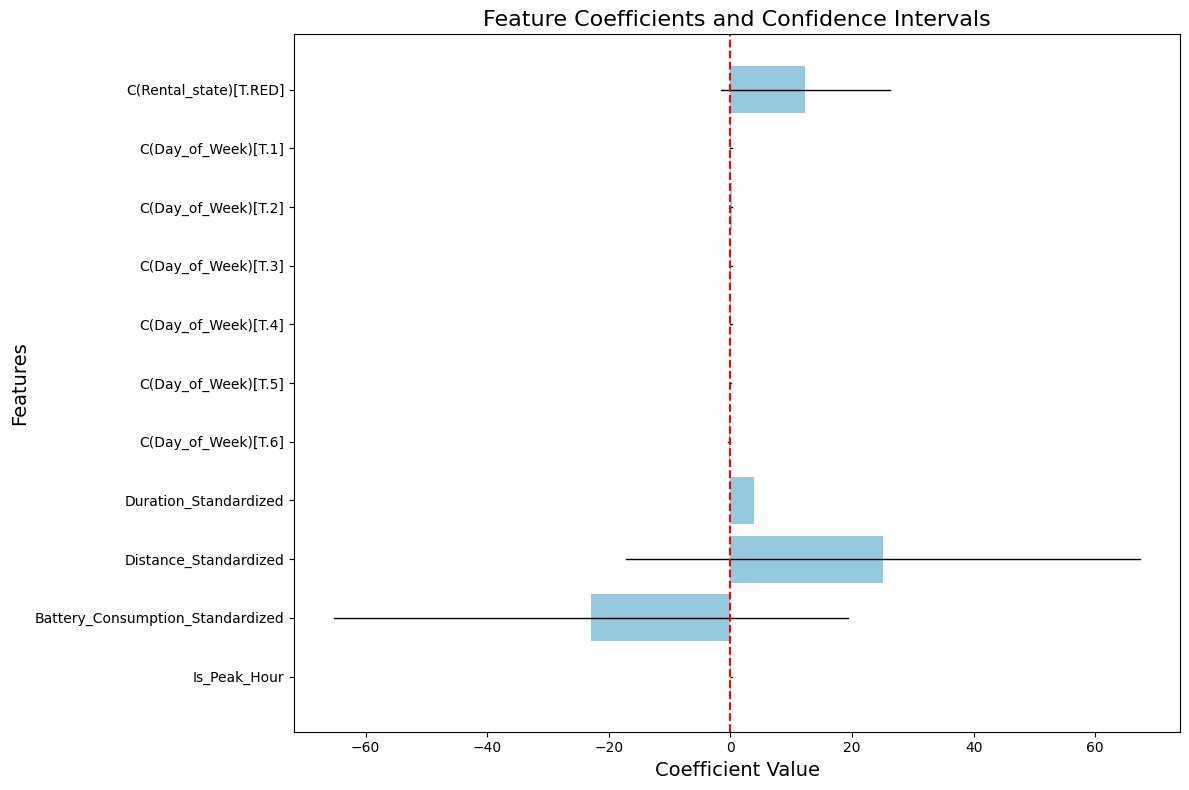

<ipython-input-3-7b9daa1c2812>:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='P-Value', y='Feature', data=p_values_df, palette='viridis', orient='h')


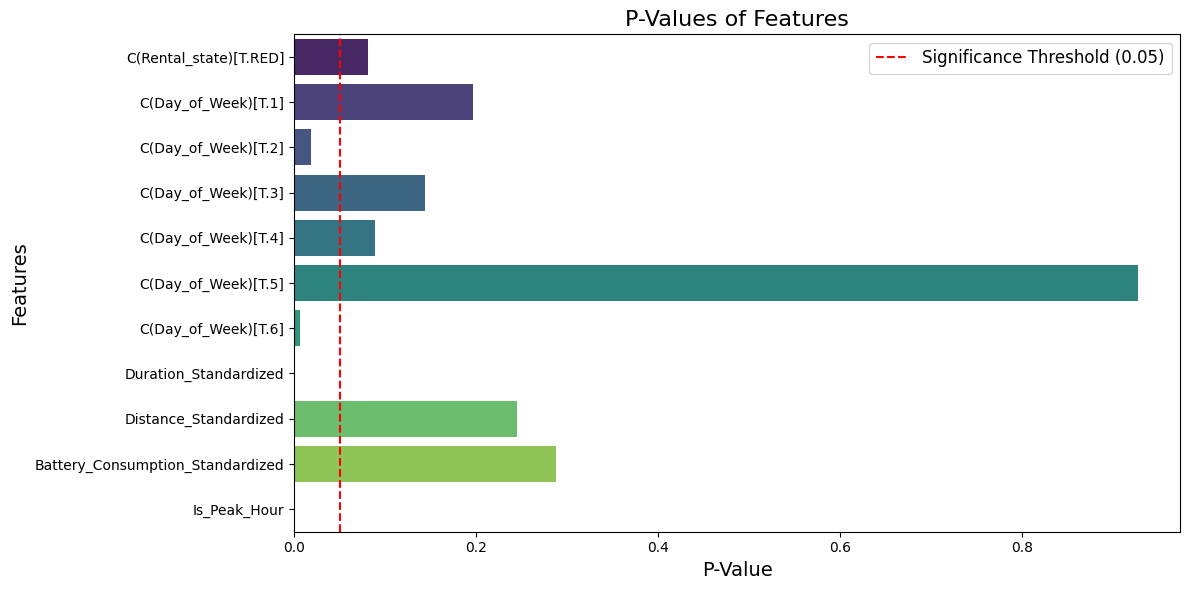

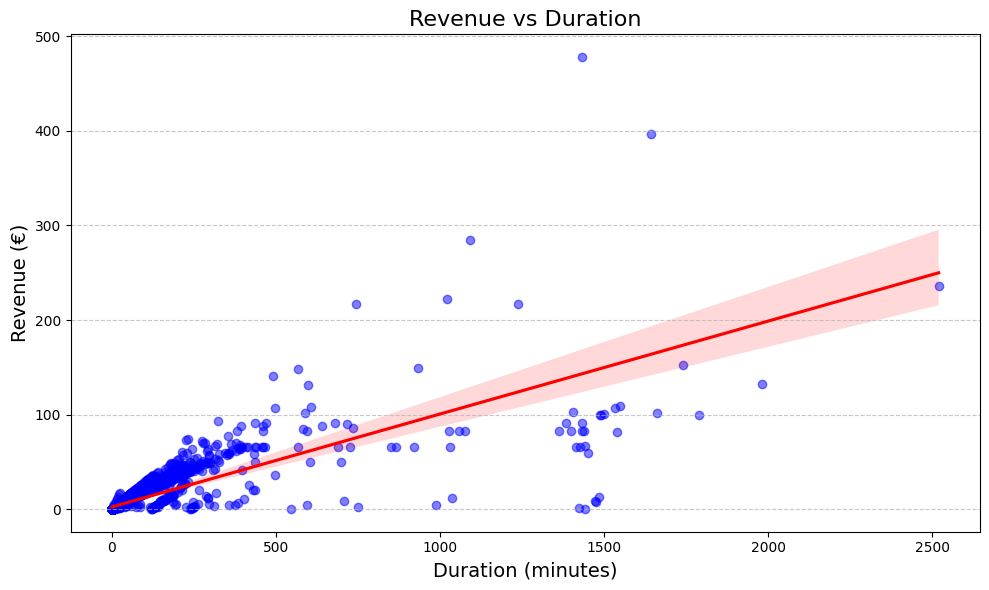

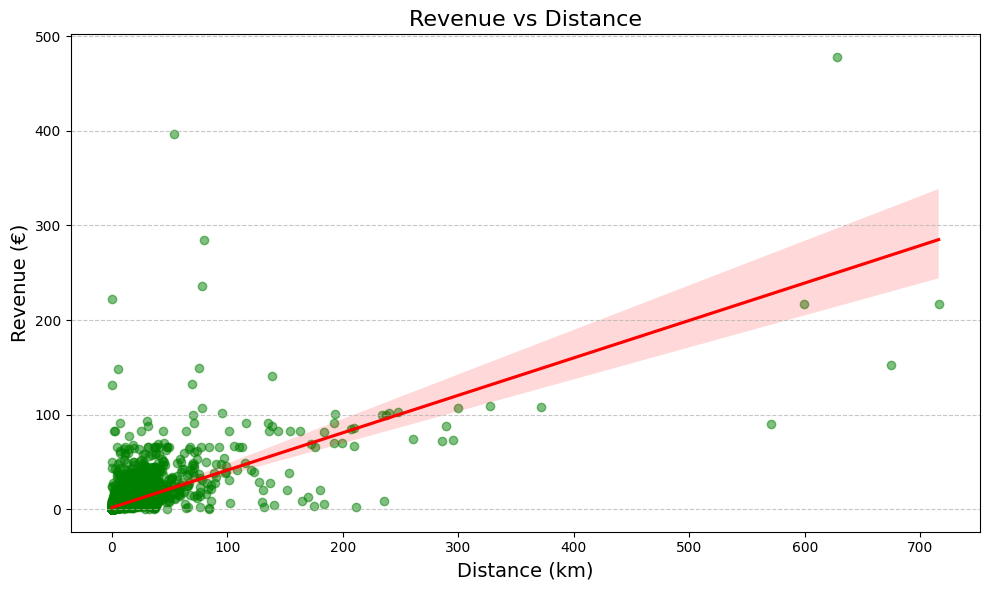

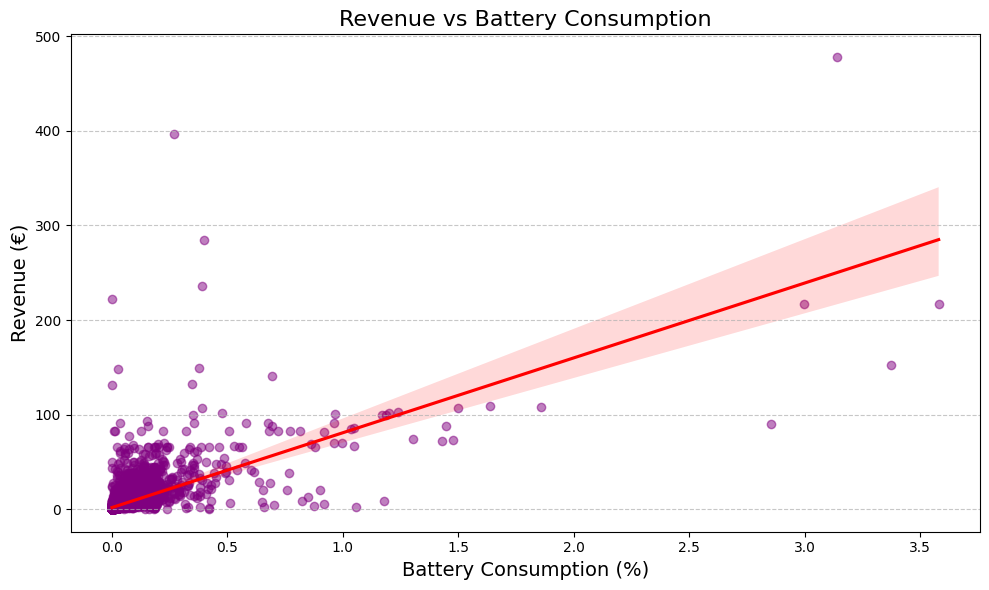

<ipython-input-3-7b9daa1c2812>:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Day_of_Week', y='Revenue', data=data, ci=None, palette='muted')
<ipython-input-3-7b9daa1c2812>:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Day_of_Week', y='Revenue', data=data, ci=None, palette='muted')


<ipython-input-3-7b9daa1c2812>:129: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y='Revenue', data=data, ci=None, marker='o', color='blue')


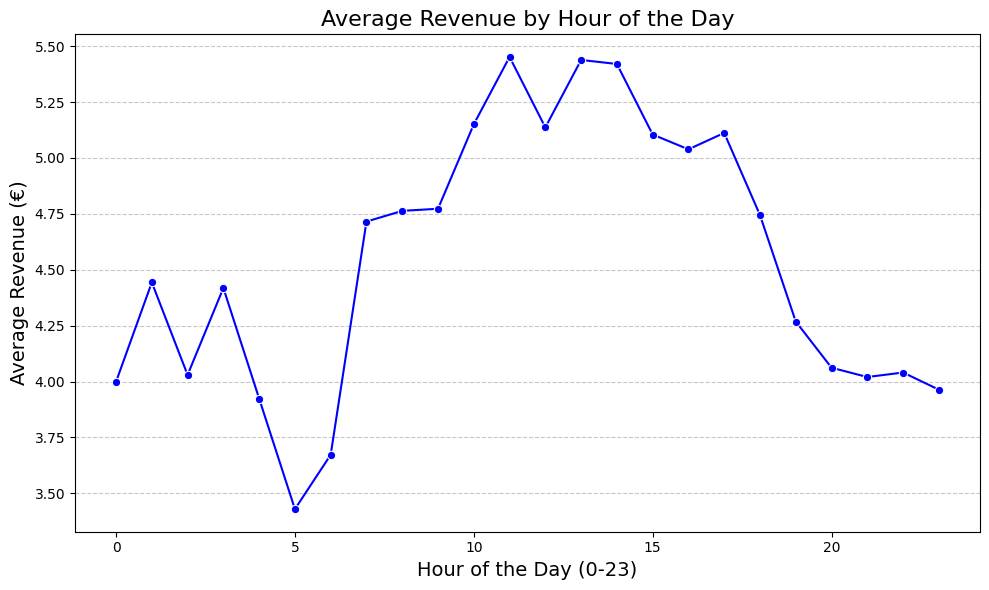


Statistical Significance:

Features with p-value < 0.05 (statistically significant): ['C(Day_of_Week)[T.2]', 'C(Day_of_Week)[T.6]', 'Duration_Standardized', 'Is_Peak_Hour']


In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("rental_data.csv")

# Convert timestamps to datetime format
data['Start'] = pd.to_datetime(data['Start'])
data['End'] = pd.to_datetime(data['End'])

# Feature Generation
# Calculate rental/idle duration in minutes
data['Duration'] = (data['End'] - data['Start']).dt.total_seconds() / 60

# Calculate battery consumption (only for rentals, i.e., when Rental_state = 'RED')
data['Battery_Consumption'] = np.where(data['Rental_state'] == 'RED', data['Distance'] * 0.005, 0)

# Generate additional features
# Identify peak rental hours (assuming peak hours are 7-9 AM and 5-7 PM)
data['Hour'] = data['Start'].dt.hour
data['Is_Peak_Hour'] = np.where((data['Hour'].between(7, 9)) | (data['Hour'].between(17, 19)), 1, 0)

# Generate day of the week feature
data['Day_of_Week'] = data['Start'].dt.dayofweek

# Prepare the data for statistical testing
# Drop rows with missing or zero revenue
data = data[data['Revenue'] > 0]

# Standardize numerical features for better interpretability in regression
data['Duration_Standardized'] = (data['Duration'] - data['Duration'].mean()) / data['Duration'].std()
data['Distance_Standardized'] = (data['Distance'] - data['Distance'].mean()) / data['Distance'].std()
data['Battery_Consumption_Standardized'] = (data['Battery_Consumption'] - data['Battery_Consumption'].mean()) / data['Battery_Consumption'].std()

# Define the formula for the regression model
formula = "Revenue ~ C(Rental_state) + Duration_Standardized + Distance_Standardized + Battery_Consumption_Standardized + Is_Peak_Hour + C(Day_of_Week)"

# Fit the model
model = ols(formula, data=data).fit()

# Display the summary of the regression model
print(model.summary())

# Visualize results
# Plot the coefficients and their confidence intervals
coefficients = model.params
conf_int = model.conf_int()
conf_int.columns = ['Lower CI', 'Upper CI']
coefficients_df = pd.concat([coefficients, conf_int], axis=1)
coefficients_df.columns = ['Coefficient', 'Lower CI', 'Upper CI']

# Filter out the intercept for visualization
coefficients_df = coefficients_df[coefficients_df.index != 'Intercept']

# Plot coefficients and confidence intervals
plt.figure(figsize=(12, 8))
sns.barplot(x=coefficients_df['Coefficient'], y=coefficients_df.index, color='skyblue', orient='h')
for i, row in coefficients_df.iterrows():
    plt.plot([row['Lower CI'], row['Upper CI']], [i, i], color='black', linewidth=1)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Coefficients and Confidence Intervals', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()
plt.show()

# P-value visualization
p_values = model.pvalues.drop('Intercept')
p_values_df = p_values.to_frame(name='P-Value').reset_index()
p_values_df.columns = ['Feature', 'P-Value']

plt.figure(figsize=(12, 6))
sns.barplot(x='P-Value', y='Feature', data=p_values_df, palette='viridis', orient='h')
plt.axvline(0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.title('P-Values of Features', fontsize=16)
plt.xlabel('P-Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Individual plots for relationships between revenue and numerical features
# Revenue vs Duration (Normal Values)
plt.figure(figsize=(10, 6))
sns.regplot(x='Duration', y='Revenue', data=data, scatter_kws={'alpha': 0.5, 'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Revenue vs Duration', fontsize=16)
plt.xlabel('Duration (minutes)', fontsize=14)
plt.ylabel('Revenue (€)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Revenue vs Distance (Normal Values)
plt.figure(figsize=(10, 6))
sns.regplot(x='Distance', y='Revenue', data=data, scatter_kws={'alpha': 0.5, 'color': 'green'}, line_kws={'color': 'red'})
plt.title('Revenue vs Distance', fontsize=16)
plt.xlabel('Distance (km)', fontsize=14)
plt.ylabel('Revenue (€)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Revenue vs Battery Consumption (Normal Values)
plt.figure(figsize=(10, 6))
sns.regplot(x='Battery_Consumption', y='Revenue', data=data, scatter_kws={'alpha': 0.5, 'color': 'purple'}, line_kws={'color': 'red'})
plt.title('Revenue vs Battery Consumption', fontsize=16)
plt.xlabel('Battery Consumption (%)', fontsize=14)
plt.ylabel('Revenue (€)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Revenue vs Day of the Week
plt.figure(figsize=(10, 6))
sns.barplot(x='Day_of_Week', y='Revenue', data=data, ci=None, palette='muted')
plt.title('Average Revenue by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week (0 = Monday, 6 = Sunday)', fontsize=14)
plt.ylabel('Average Revenue (€)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Revenue vs Hour of the Day
plt.figure(figsize=(10, 6))
sns.lineplot(x='Hour', y='Revenue', data=data, ci=None, marker='o', color='blue')
plt.title('Average Revenue by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day (0-23)', fontsize=14)
plt.ylabel('Average Revenue (€)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Statistical significance explanation
print("\nStatistical Significance:\n")
significant_features = model.pvalues[model.pvalues < 0.05].index.tolist()
print(f"Features with p-value < 0.05 (statistically significant): {significant_features}")
